In [1]:
import pandas as pd
from sqlalchemy import create_engine
import statsmodels.api as sm
from linearmodels.panel import PanelOLS
from linearmodels.panel import PooledOLS
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.use('ggplot')
mpl.rcParams['figure.dpi'] = 150

In [2]:
engine = create_engine("sqlite:///GDS.db")
df_emissions = pd.read_sql_table('Emissions_Data_Joined', engine)
df_emissions['Year'] = df_emissions['Year'].astype(int)

df_sectors = pd.read_sql_table('Sectors', engine)
df_fin = pd.read_sql_table('FinancialsTableFinal', engine)

In [3]:
df_fin['Year'] = df_fin['Date'].str[:4].astype(int)+1
df_fin.drop(columns='Date', inplace=True)

In [4]:
df_panel = df_emissions.merge(df_sectors, on='Company Name').merge(
    df_fin, on=['Company Name', 'Year']).set_index(['Company Name', 'Year'])

df_panel = df_panel.loc[~df_panel['Capital Expenditures'].isna()] # Drop rows with missing values

In [5]:
primary = ['Industrials', 'Materials', 'Utilities']
df_panel.loc[~df_panel['Industry'].isin(primary), 'Industry'] = 'Tertiary'
df_panel.loc[df_panel['Industry'].isin(primary), 'Industry'] = 'Primary'

df_panel['Industry'].value_counts()

Industry
Tertiary    239
Primary     127
Name: count, dtype: int64

In [6]:
df_panel = pd.get_dummies(df_panel, columns=['Industry'], drop_first=True)

In [7]:
df_panel

Scope_1_emissions_(tCO₂e)  \
Company Name                 Year                             
37 Interactive Entertainment 2018                         -   
                             2019                       129   
                             2020                       169   
                             2021                       152   
Accor                        2018                    280706   
...                                                     ...   
Xylem Inc                    2021                     47707   
Yum! Brands, Inc.            2018                     48047   
                             2019                     23545   
                             2020                     38907   
                             2021                     39013   

                                  Scope_2_emissions_(tCO₂e)_Location  \
Company Name                 Year                                      
37 Interactive Entertainment 2018                                  -   
                             2019                               2701   
                             2020                               2395   
                             2021                               1794   
Accor                        2018                            1829278   
...                                                              ...   
Xylem Inc                    2021                              44569   
Yum! Brands, Inc.            2018                             155439   
                             2019                             140341   
                             2020                             128129   
                             2021                             117621   

                                  Scope_2_emissions_(tCO₂e)_Market  \
Company Name                 Year                                    
37 Interactive Entertainment 2018                                -   
                             2019                                -   
                             2020                                -   
                             2021                                -   
Accor                        2018                                -   
...                                                            ...   
Xylem Inc                    2021                            18214   
Yum! Brands, Inc.            2018                           159403   
                             2019                           144313   
                             2020                           130953   
                             2021                           112665   

                                        Revenue  Net Profit Margin, (%)  \
Company Name                 Year                                         
37 Interactive Entertainment 2018  9.512055e+08                0.261856   
                             2019  1.110127e+09                0.132130   
                             2020  1.899959e+09                0.159881   
                             2021  2.206851e+09                0.191737   
Accor                        2018  3.327695e+09                0.123288   
...                                         ...                     ...   
Xylem Inc                    2021  4.876000e+09                0.052092   
Yum! Brands, Inc.            2018  5.878000e+09                0.301803   
                             2019  5.688000e+09                0.259494   
                             2020  5.597000e+09                0.231195   
                             2021  5.652000e+09                0.159943   

                                   Current Ratio       ROE  Debt to Equity  \
Company Name                 Year                                            
37 Interactive Entertainment 2018        2.60977  0.230958        0.105192   
                             2019        2.09920  0.168853        0.113814   
                             2020        2.44392  0.300850        0.082679   


-----------------------------------------------
Want to seperate out each of the emission scopes so we can take all observations with values for that scope.
i.e. We want to include a company which has Scope 1 emissions but no Scope 2 Location Based emissions in our model for Scope 1 emissions. This would not be possible if we just dropped them from main df. 

In [8]:
x_vars = df_panel.columns[3:]

df_scope1 = df_panel[x_vars].merge(df_panel['Scope_1_emissions_(tCO₂e)'],
                                    left_index=True, right_index=True)
df_scope2_loc = df_panel[x_vars].merge(df_panel['Scope_2_emissions_(tCO₂e)_Location'],
                                        left_index=True, right_index=True)
df_scope2_mkt = df_panel[x_vars].merge(df_panel['Scope_2_emissions_(tCO₂e)_Market'],
                                        left_index=True, right_index=True)

------------------------------------
Fit Scope 1 model

In [9]:
# Drop observations without emissions data
df_scope1 = df_scope1.loc[df_scope1['Scope_1_emissions_(tCO₂e)'] != '-'].astype(float)
df_scope2_loc = df_scope2_loc.loc[df_scope2_loc['Scope_2_emissions_(tCO₂e)_Location'] != '-'].astype(float)
df_scope2_mkt = df_scope2_mkt.loc[df_scope2_mkt['Scope_2_emissions_(tCO₂e)_Market'] != '-'].astype(float)

In [10]:
x = sm.add_constant(df_scope1[x_vars])
y = np.log(df_scope1[['Scope_1_emissions_(tCO₂e)']])

model1 = PanelOLS(dependent=y, exog=x, time_effects=True)
res1 = model1.fit()
res1.summary

Dep. Variable:,Scope_1_emissions_(tCO₂e),R-squared:,0.2577
Estimator:,PanelOLS,R-squared (Between):,0.2799
No. Observations:,354,R-squared (Within):,-0.9031
Date:,"Thu, Jun 22 2023",R-squared (Overall):,0.2567
Time:,12:15:33,Log-likelihood,-785.91
Cov. Estimator:,Unadjusted,,
,,F-statistic:,17.010
Entities:,92,P-value,0.0000
Avg Obs:,3.8478,Distribution:,"F(7,343)"
Min Obs:,2.0000,,
Max Obs:,4.0000,F-statistic (robust):,17.010


-------------------------------
Fit Scope 2 Location Based model

In [11]:
x = sm.add_constant(df_scope2_loc[x_vars])
y = np.log(df_scope2_loc[['Scope_2_emissions_(tCO₂e)_Location']])

model2_loc = PanelOLS(dependent=y, exog=x, time_effects=True)
res2_loc = model2_loc.fit()
res2_loc.summary

Dep. Variable:,Scope_2_emissions_(tCO₂e)_Location,R-squared:,0.2703
Estimator:,PanelOLS,R-squared (Between):,0.3256
No. Observations:,349,R-squared (Within):,-5.6880
Date:,"Thu, Jun 22 2023",R-squared (Overall):,0.2674
Time:,12:15:33,Log-likelihood,-686.58
Cov. Estimator:,Unadjusted,,
,,F-statistic:,17.890
Entities:,92,P-value,0.0000
Avg Obs:,3.7935,Distribution:,"F(7,338)"
Min Obs:,2.0000,,
Max Obs:,4.0000,F-statistic (robust):,17.890


-------------------------
Fit Scope 2 Market Based model

In [12]:
x = sm.add_constant(df_scope2_mkt[x_vars])
y = np.log(df_scope2_mkt[['Scope_2_emissions_(tCO₂e)_Market']])

model2_mkt = PanelOLS(dependent=y, exog=x, time_effects=True)
res2_mkt = model2_mkt.fit()
res2_mkt.summary

Dep. Variable:,Scope_2_emissions_(tCO₂e)_Market,R-squared:,0.1652
Estimator:,PanelOLS,R-squared (Between):,0.1690
No. Observations:,322,R-squared (Within):,-0.2663
Date:,"Thu, Jun 22 2023",R-squared (Overall):,0.1616
Time:,12:15:34,Log-likelihood,-708.65
Cov. Estimator:,Unadjusted,,
,,F-statistic:,8.7909
Entities:,91,P-value,0.0000
Avg Obs:,3.5385,Distribution:,"F(7,311)"
Min Obs:,1.0000,,
Max Obs:,4.0000,F-statistic (robust):,8.7909


------------------------------------
Examine time effects of models

In [13]:
res1.estimated_effects.round(decimals=2).droplevel(0).drop_duplicates().sort_index(ascending=True)

,estimated_effects
Year,
2018,0.31
2019,-0.03
2020,-0.10
2021,-0.13


In [14]:
res2_loc.estimated_effects.round(decimals=2).droplevel(0).drop_duplicates().sort_index(ascending=True)

,estimated_effects
Year,
2018,0.32
2019,-0.03
2020,-0.13
2021,-0.12


In [15]:
res2_mkt.estimated_effects.round(decimals=2).droplevel(0).drop_duplicates().sort_index(ascending=True)

,estimated_effects
Year,
2018,0.39
2019,0.28
2020,-0.12
2021,-0.43


F-Test for poolability non-significant for all 3 models at 5% level. We fail to reject the null hypothesis that the time effects are jointly 0 for all timepoints, and implement a pooled model instead.

In [16]:
x = sm.add_constant(df_scope1[x_vars])
y = np.log(df_scope1[['Scope_1_emissions_(tCO₂e)']])

model1 = PooledOLS(dependent=y, exog=x)
res1 = model1.fit()
res1.summary

Dep. Variable:,Scope_1_emissions_(tCO₂e),R-squared:,0.2569
Estimator:,PooledOLS,R-squared (Between):,0.2793
No. Observations:,354,R-squared (Within):,-0.8607
Date:,"Thu, Jun 22 2023",R-squared (Overall):,0.2569
Time:,12:15:34,Log-likelihood,-786.89
Cov. Estimator:,Unadjusted,,
,,F-statistic:,17.086
Entities:,92,P-value,0.0000
Avg Obs:,3.8478,Distribution:,"F(7,346)"
Min Obs:,2.0000,,
Max Obs:,4.0000,F-statistic (robust):,17.086


In [17]:
x = sm.add_constant(df_scope2_loc[x_vars])
y = np.log(df_scope2_loc[['Scope_2_emissions_(tCO₂e)_Location']])

model2_loc = PooledOLS(dependent=y, exog=x)
res2_loc = model2_loc.fit()
res2_loc.summary

Dep. Variable:,Scope_2_emissions_(tCO₂e)_Location,R-squared:,0.2677
Estimator:,PooledOLS,R-squared (Between):,0.3258
No. Observations:,349,R-squared (Within):,-5.6386
Date:,"Thu, Jun 22 2023",R-squared (Overall):,0.2677
Time:,12:15:34,Log-likelihood,-688.34
Cov. Estimator:,Unadjusted,,
,,F-statistic:,17.804
Entities:,92,P-value,0.0000
Avg Obs:,3.7935,Distribution:,"F(7,341)"
Min Obs:,2.0000,,
Max Obs:,4.0000,F-statistic (robust):,17.804


In [18]:
x = sm.add_constant(df_scope2_mkt[x_vars])
y = np.log(df_scope2_mkt[['Scope_2_emissions_(tCO₂e)_Market']])

model2_mkt = PooledOLS(dependent=y, exog=x)
res2_mkt = model2_mkt.fit()
res2_mkt.summary

Dep. Variable:,Scope_2_emissions_(tCO₂e)_Market,R-squared:,0.1627
Estimator:,PooledOLS,R-squared (Between):,0.1647
No. Observations:,322,R-squared (Within):,-0.2337
Date:,"Thu, Jun 22 2023",R-squared (Overall):,0.1627
Time:,12:15:34,Log-likelihood,-711.98
Cov. Estimator:,Unadjusted,,
,,F-statistic:,8.7164
Entities:,91,P-value,0.0000
Avg Obs:,3.5385,Distribution:,"F(7,314)"
Min Obs:,1.0000,,
Max Obs:,4.0000,F-statistic (robust):,8.7164


----------------------
Plotting Fitted values

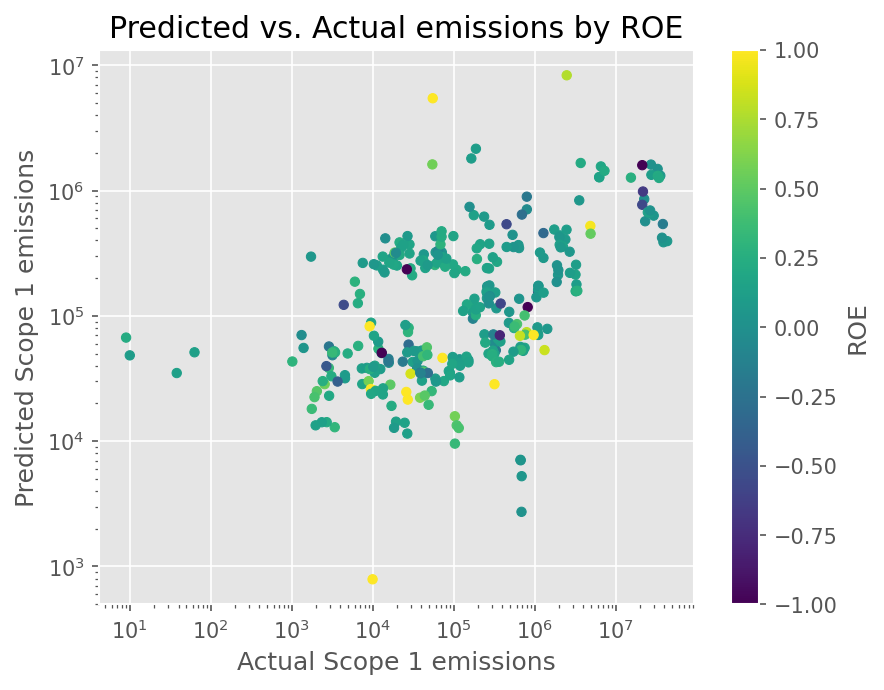

In [26]:
norm = mpl.colors.Normalize(vmin=-1, vmax=1)

np.exp(model1.predict(params=res1.params, exog=x)).merge(
    df_scope1[['Scope_1_emissions_(tCO₂e)', 'ROE']], left_index=True, right_index=True).plot.scatter(
        x='Scope_1_emissions_(tCO₂e)', y='predictions', c='ROE', colormap='viridis', norm=norm)
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Predicted Scope 1 emissions')
plt.xlabel('Actual Scope 1 emissions')
plt.title('Predicted vs. Actual emissions by ROE')
plt.show()

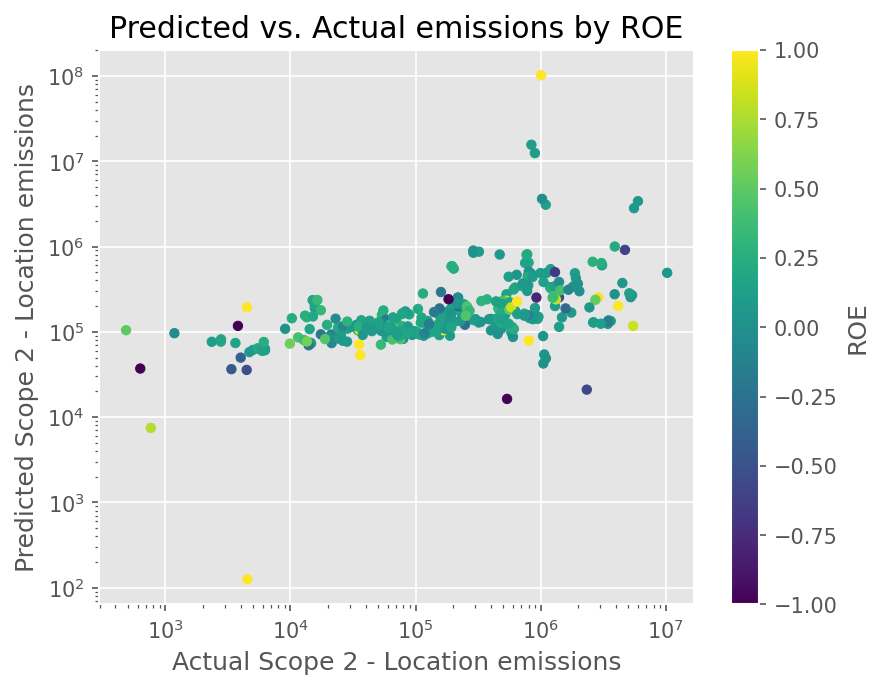

In [25]:
np.exp(model2_loc.predict(params=res2_loc.params, exog=x)).merge(
    df_scope2_loc[['Scope_2_emissions_(tCO₂e)_Location', 'ROE']], left_index=True, right_index=True).plot.scatter(
        x='Scope_2_emissions_(tCO₂e)_Location', y='predictions', c='ROE', colormap='viridis', norm=norm)
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Predicted Scope 2 - Location emissions')
plt.xlabel('Actual Scope 2 - Location emissions')
plt.title('Predicted vs. Actual emissions by ROE')
plt.show()

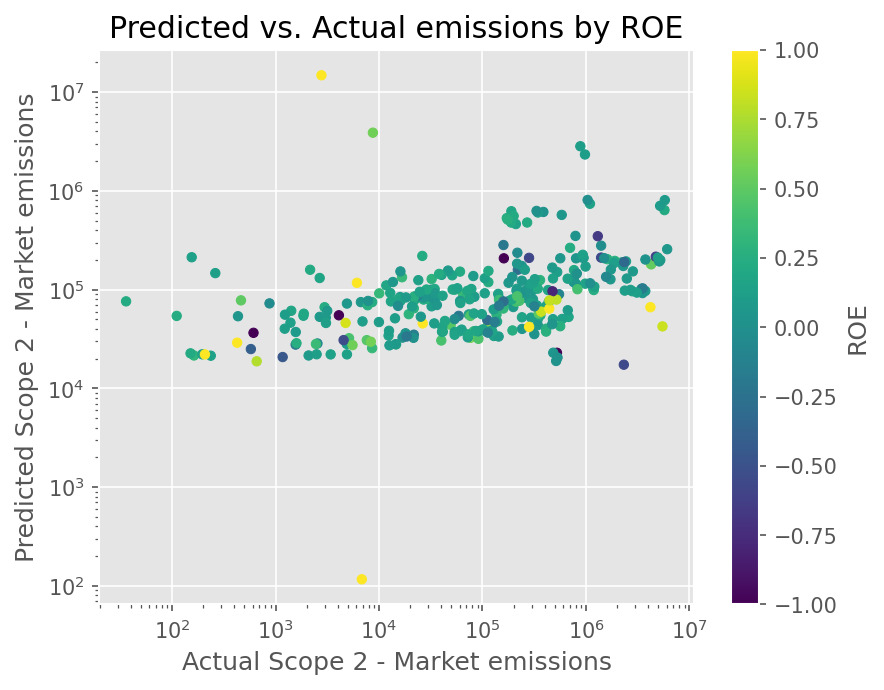

In [24]:
np.exp(model2_mkt.predict(params=res2_mkt.params, exog=x)).merge(
    df_scope2_mkt[['Scope_2_emissions_(tCO₂e)_Market', 'ROE']], left_index=True, right_index=True).plot.scatter(
        x='Scope_2_emissions_(tCO₂e)_Market', y='predictions', c='ROE', colormap='viridis', norm=norm)
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Predicted Scope 2 - Market emissions')
plt.xlabel('Actual Scope 2 - Market emissions')
plt.title('Predicted vs. Actual emissions by ROE')
plt.show()